In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import datasets
import matplotlib.pyplot as plt
import optax

import nnx

/home/cris/nnx/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = datasets.load_dataset("mnist")
X_train = np.array(np.stack(dataset["train"]["image"]), dtype=np.uint8)[..., None]
y_train = np.array(dataset["train"]["label"], dtype=np.uint8)
X_test = np.array(np.stack(dataset["test"]["image"]), dtype=np.uint8)[..., None]
y_test = np.array(dataset["test"]["label"], dtype=np.uint8)

Found cached dataset mnist (/home/cris/.cache/huggingface/datasets/mnist/mnist/1.0.0/9d494b7f466d6931c64fb39d58bb1249a4d85c9eb9865d9bc20960b999e2a332)
100%|██████████| 2/2 [00:00<00:00, 489.16it/s]


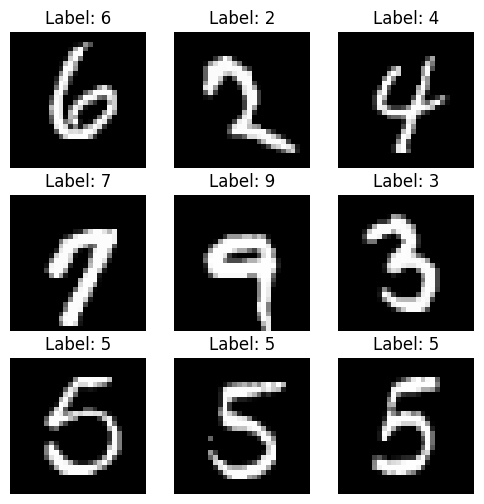

In [3]:
# plot a 3x3 grid of MNIST digits
idxs = np.random.randint(0, len(X_train), size=(3, 3))
fig, axes = plt.subplots(3, 3, figsize=(3*2, 3*2))

for i in range(3):
    for j in range(3):
        axes[i, j].imshow(X_train[idxs[i, j]], cmap="gray")
        axes[i, j].axis("off")
        axes[i, j].set_title(f"Label: {y_train[idxs[i, j]]}")

plt.show()

In [4]:
class CNN(nnx.Module):
  def __init__(self, *, ctx: nnx.Context):
    self.conv1 = nnx.Conv(1, 32, kernel_size=(3, 3), ctx=ctx)
    self.conv2 = nnx.Conv(32, 64, kernel_size=(3, 3), ctx=ctx)
    self.linear1 = nnx.Linear(7*7*64, 256, ctx=ctx)
    self.linear2 = nnx.Linear(256, 10, ctx=ctx)

  def __call__(self, x: jax.Array) -> jax.Array:
    x = self.conv1(x)
    x = nnx.relu(x)
    x = nnx.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = self.conv2(x)
    x = nnx.relu(x)
    x = nnx.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  # flatten
    x = self.linear1(x)
    x = nnx.relu(x)
    x = self.linear2(x)
    return x
  
model = CNN(ctx=nnx.context(0))

jax.tree_map(jnp.shape, model.get_state())

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


State({
  'conv1/bias': Variable(
    collection='params',
    value=(32,)
  ),
  'conv1/kernel': Variable(
    collection='params',
    value=(3, 3, 1, 32)
  ),
  'conv2/bias': Variable(
    collection='params',
    value=(64,)
  ),
  'conv2/kernel': Variable(
    collection='params',
    value=(3, 3, 32, 64)
  ),
  'linear1/bias': Variable(
    collection='params',
    value=(256,)
  ),
  'linear1/kernel': Variable(
    collection='params',
    value=(3136, 256)
  ),
  'linear2/bias': Variable(
    collection='params',
    value=(10,)
  ),
  'linear2/kernel': Variable(
    collection='params',
    value=(256, 10)
  )
})

In [5]:
for step in range(10):
    idxs = np.random.randint(0, len(X_train), size=32)
    x = jnp.array(X_train[idxs])
    y = jnp.array(y_train[idxs])

    def loss_fn(model: CNN):
        logits = model(x)
        return optax.softmax_cross_entropy_with_integer_labels(logits, y).mean()
    
    loss, grads = nnx.value_and_grad(loss_fn, wrt="params")(model)
    params = model.filter("params")
    params = jax.tree_map(lambda w, g: w - 0.001 * g, params, grads)

    model.update_state(params)
    print(f"Step {step}: loss={loss:.4f}")

Step 0: loss=62.6761
Step 1: loss=139.6331
Step 2: loss=65.8653
Step 3: loss=14.9191
Step 4: loss=7.7782
Step 5: loss=4.8600
Step 6: loss=2.7155
Step 7: loss=2.5674
Step 8: loss=2.2204
Step 9: loss=1.6144


In [6]:
params, moduledef = model.partition("params")

@jax.jit
def train_step(params: nnx.State, x, y):
    def loss_fn(params):
        logits, _updates = moduledef.apply(params)(x)
        return optax.softmax_cross_entropy_with_integer_labels(logits, y).mean()
    
    loss, grads = jax.value_and_grad(loss_fn)(params)
    params = jax.tree_map(lambda w, g: w - 0.001 * g, params, grads)

    return loss, params

In [7]:
for step in range(10):
    idxs = np.random.randint(0, len(X_train), size=32)
    x = jnp.array(X_train[idxs])
    y = jnp.array(y_train[idxs])

    loss, params = train_step(params, x, y)
    print(f"Step {step}: loss={loss:.4f}")

model.update_state(params)

Step 0: loss=1.6476
Step 1: loss=1.4571
Step 2: loss=1.1790
Step 3: loss=1.3965
Step 4: loss=1.3250
Step 5: loss=1.0368
Step 6: loss=0.7451
Step 7: loss=1.2576
Step 8: loss=1.1498
Step 9: loss=0.8362


In [8]:
state = nnx.TrainState(
    apply_fn=moduledef.apply,
    params=params,
    tx=optax.adam(0.001), 
)

@jax.jit
def train_step(state: nnx.TrainState, x, y):

    def loss_fn(params):
        logits, _updates = state.apply_fn(params)(x)
        return optax.softmax_cross_entropy_with_integer_labels(logits, y).mean()
    
    loss, grads = jax.value_and_grad(loss_fn)(state.params)

    state = state.apply_gradients(grads=grads)

    return loss, state

@jax.jit
def eval_step(state: nnx.TrainState, x, y):
    logits, _updates = state.apply_fn(state.params)(x)
    metrics = {
        'accuracy': jnp.mean(jnp.argmax(logits, axis=-1) == y),
        'loss': optax.softmax_cross_entropy_with_integer_labels(logits, y).mean()
    }
    return metrics

In [9]:
total_steps = 1000
eval_every = 100

for step in range(total_steps):
    if step % eval_every == 0:
        metrics = eval_step(state, jnp.array(X_test), jnp.array(y_test))
        print(f"Step {step}: {metrics}")

    idxs = np.random.randint(0, len(X_train), size=32)
    x = jnp.array(X_train[idxs])
    y = jnp.array(y_train[idxs])

    loss, state = train_step(state, x, y)

metrics = eval_step(state, jnp.array(X_test), jnp.array(y_test))
print(f"Final metrics: {metrics}")

Step 0: {'accuracy': Array(0.67939997, dtype=float32), 'loss': Array(0.9810114, dtype=float32)}
Step 100: {'accuracy': Array(0.9472, dtype=float32), 'loss': Array(0.16678722, dtype=float32)}
Step 200: {'accuracy': Array(0.9504, dtype=float32), 'loss': Array(0.16086154, dtype=float32)}
Step 300: {'accuracy': Array(0.9515, dtype=float32), 'loss': Array(0.16186629, dtype=float32)}
Step 400: {'accuracy': Array(0.96959996, dtype=float32), 'loss': Array(0.09600201, dtype=float32)}
Step 500: {'accuracy': Array(0.9715, dtype=float32), 'loss': Array(0.09574296, dtype=float32)}
Step 600: {'accuracy': Array(0.97279996, dtype=float32), 'loss': Array(0.08801217, dtype=float32)}
Step 700: {'accuracy': Array(0.97309995, dtype=float32), 'loss': Array(0.08728758, dtype=float32)}
Step 800: {'accuracy': Array(0.98069996, dtype=float32), 'loss': Array(0.0568619, dtype=float32)}
Step 900: {'accuracy': Array(0.9812, dtype=float32), 'loss': Array(0.06021253, dtype=float32)}
Final metrics: {'accuracy': Array(

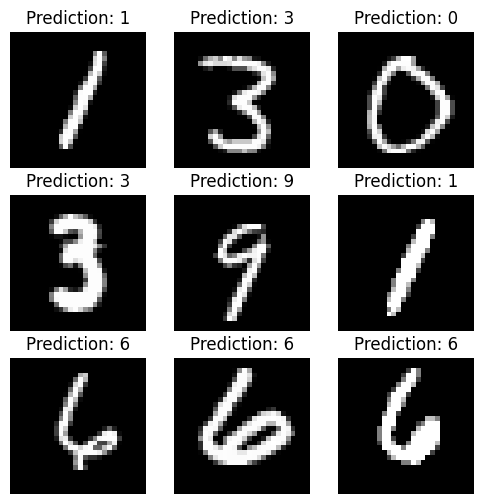

In [10]:
model.update_state(state.params)

# plot a 3x3 grid of MNIST digits
idxs = np.random.randint(0, len(X_test), size=(3, 3))
fig, axes = plt.subplots(3, 3, figsize=(3*2, 3*2))

for i in range(3):
    for j in range(3):
        logits = model(jnp.array([X_test[idxs[i, j]]]))
        axes[i, j].imshow(X_test[idxs[i, j]], cmap="gray")
        axes[i, j].axis("off")
        axes[i, j].set_title(f"Prediction: {jnp.argmax(logits)}")